#### -----------------------------------------------------------------------------<br>Copyright (c) 2022, Lucid Vision Labs, Inc.
##### THE  SOFTWARE  IS  PROVIDED  "AS IS",  WITHOUT  WARRANTY  OF  ANY  KIND,<br>EXPRESS  OR  IMPLIED,  INCLUDING  BUT  NOT  LIMITED  TO  THE  WARRANTIES<br>OF  MERCHANTABILITY,  FITNESS  FOR  A  PARTICULAR  PURPOSE  AND<br>NONINFRINGEMENT.  IN  NO  EVENT  SHALL  THE  AUTHORS  OR  COPYRIGHT  HOLDERS<br>BE  LIABLE  FOR  ANY  CLAIM,  DAMAGES  OR  OTHER  LIABILITY,  WHETHER  IN  AN<br>ACTION  OF  CONTRACT,  TORT  OR  OTHERWISE,  ARISING  FROM,  OUT  OF  OR  IN<br>CONNECTION  WITH  THE  SOFTWARE  OR  THE  USE  OR  OTHER  DEALINGS  IN  THE  SOFTWARE.<br>-----------------------------------------------------------------------------

In [32]:
import time

import numpy as np # pip3 install numpy
import cv2  # pip3 install opencv-python
from matplotlib import pyplot as plt # pip3 install matplotlib
# pip3 install pillow
from PIL import Image as PIL_Image
from PIL import ImageTk as PIL_ImageTk
# pip3 install tk / or 'sudo apt-get install python3-tk' for linux
from tkinter import *

from arena_api import enums
from arena_api.system import system
from arena_api.buffer import BufferFactory

#### Acquisition: Introduction
>	This example introduces the basics of image acquisition. This
	includes setting image acquisition and buffer handling modes,
	setting the device to automatically negotiate packet size, and
	setting the stream packet resend node before starting the image
	stream. The example then acquires an image by grabbing and
	requeuing a single buffer and retrieving its data, before stopping
	the stream. It then displays the image using Matplotlib, OpenCV and Tkinter.

In [49]:
"""
Waits for the user to connect a device before raising an exception if it fails
"""
tries = 0
tries_max = 6
sleep_time_secs = 10
devices = None
while tries < tries_max:  # Wait for device for 60 seconds
    devices = system.create_device()
    if not devices:
        print(
            f'Try {tries+1} of {tries_max}: waiting for {sleep_time_secs} '
            f'secs for a device to be connected!')
        for sec_count in range(sleep_time_secs):
            time.sleep(1)
            print(f'{sec_count + 1 } seconds passed ',
                    '.' * sec_count, end='\r')
        tries += 1
    else:
        print(f'Created {len(devices)} device(s)')
        break
else:
    raise Exception(f'No device found! Please connect a device and run '
                    f'the example again.')

device = devices[0]
nodemap = device.nodemap
print(f'Device used in the example:\n\t{device}')

Created 6 device(s)
Device used in the example:
	('1c:0f:af:05:62:b8', 'TRI023S-C', '', '169.254.185.98')


##### Store initial values
> These initial values are restored to the device after the example is completed

In [50]:
nodes = device.nodemap.get_node(['Width', 'Height', 'PixelFormat'])
width_initial = nodes['Width'].value
height_initial = nodes['Height'].value
pixel_format_initial = nodes['PixelFormat'].value

##### Set features before streaming.-------------------------------------------

In [51]:
# Get stream nodemap
stream_nodemap = device.tl_stream_nodemap

# Enable stream auto negotiate packet size
stream_nodemap['StreamAutoNegotiatePacketSize'].value = True

# Enable stream packet resend
stream_nodemap['StreamPacketResendEnable'].value = True

# Set width and height to their max values
print('Setting \'Width\' and \'Height\' Nodes value to their max values')
nodes['Width'].value = nodes['Width'].max
nodes['Height'].value = nodes['Height'].max

# Setting pixel format 
new_pixel_format = 'Mono8'
print(f'Setting \'PixelFormat\' to \'{new_pixel_format}\'')
nodes['PixelFormat'].value = new_pixel_format

Setting 'Width' and 'Height' Nodes value to their max values


Exception: 

SaveC ERROR :
	SC_ERR_ACCESS_DENIED -1005



##### Convert to BGR8 format
> Allows images to be easily displayed using matplotlib and opencv-python

In [44]:
def convert_buffer_to_BGR8(buffer):

    if (buffer.pixel_format == enums.PixelFormat.BGR8):
        return buffer
    print('Converting image buffer pixel format to BGR8 ')
    return BufferFactory.convert(buffer, enums.PixelFormat.BGR8)


##### Demonstrates Acquisition
> - sets acquisition mode
> - sets buffer handling mode
> - enables auto negotiate packet size
> - enables packet resend
> - starts the stream
> - gets a number of images
> - prints information from images
> - requeues buffers
> - stops the stream

##### Grab images -------------------------------------------------------------
> - Starting the stream allocates buffers, which can be passed in as
 an argument (default: 10), and begins filling them with data.
 Buffers must later be requeued to avoid memory leaks.<br>
> - 'device.get_buffer()' with no arguments returns only one buffer
     the buffer is in the rgb layout
> - 'device.requeue_buffer()' takes a buffer or many buffers in a list or tuple

In [45]:
buffer_BGR8 = None
np_array_reshaped = None

with device.start_stream(1):
    print(f'Stream started with 1 buffers')
    
    print('\tGet one buffer')
    buffer = device.get_buffer()

    # Print some info about the image in the buffer
    print(f'\t\tbuffer received   | '
        f'Width = {buffer.width} pxl, '
        f'Height = {buffer.height} pxl, '
        f'Pixel Format = {buffer.pixel_format.name}')

    # Converting to BGR8 format
    print('\tConverting to BGR8 format')
    buffer_BGR8 = convert_buffer_to_BGR8(buffer)

    # Requeue to release buffer memory
    print('Requeuing device buffer')
    device.requeue_buffer(buffer)

    # Get a copy so it can be used after the buffer is requeued
    print('\tConvert image buffer to a numpy array')
    buffer_bytes_per_pixel = int(len(buffer_BGR8.data)/(buffer_BGR8.width * buffer_BGR8.height))
    np_array = np.asarray(buffer_BGR8.data, dtype=np.uint8)
    np_array_reshaped = np_array.reshape(buffer_BGR8.height, buffer_BGR8.width, buffer_bytes_per_pixel)

Stream started with 1 buffers
	Get one buffer
		buffer received   | Width = 1920 pxl, Height = 1200 pxl, Pixel Format = Mono8
	Converting to BGR8 format
Converting image buffer pixel format to BGR8 
Requeuing device buffer
	Convert image buffer to a numpy array


##### Display image in the correct format for matplot


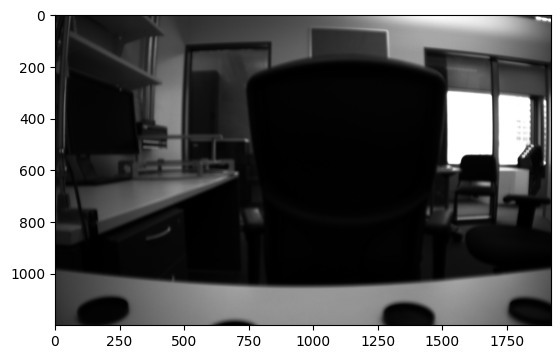

In [46]:
np_array_shaped_rgb = cv2.cvtColor(np_array_reshaped, cv2.COLOR_BGR2RGB)
plt.imshow(np_array_shaped_rgb)

##### Display image using opencv
> The array is already in BGR wich is what opencv is expecting
    so no conversion is needed like what is done for plt.imshow()

In [ ]:
cv2.imshow("window_title", np_array_reshaped)

# wait for user key before closing it
cv2.waitKey(0)

cv2.destroyAllWindows()

##### Open image in a sperate window using tkinter

In [ ]:
print('Creating \'PIL.Image\' instance from Numpy array')
pil_image = PIL_Image.fromarray(np_array_reshaped)

print('Creating a Tkinter readable image from \'PIL.Image\' instance')
root = Tk()
pil_imagetk_photoimage = PIL_ImageTk.PhotoImage(pil_image)

label = Label(root, image=pil_imagetk_photoimage)
label.pack()
root.mainloop()

##### The buffer factory gives a converted copy of the device buffer, so destroy the image copy to prevent memory leaks


In [ ]:
BufferFactory.destroy(buffer_BGR8)

##### Clean up ----------------------------------------------------------------
> - Restore initial values to the device.
> - Stop stream.
> - Destroy device. This call is optional and will automatically be
  called for any remaining devices when the system module is unloading.

In [ ]:
print("Stream stopped")
device.stop_stream()

print("Return nodes to initial values")
nodes['Width'].value = width_initial
nodes['Height'].value = height_initial
nodes['PixelFormat'].value = pixel_format_initial

system.destroy_device()
print('Destroyed all created devices')